In [3]:
amazon["category"][0]

'Computers&Accessories|Accessories&Peripherals|Cables&Accessories|Cables|USBCables'

In [4]:
import pandas as pd
amazon = pd.read_csv('../data/source/amazon.csv')
amazon["base_category"] = amazon["category"].str.split("|").str[0]
amazon["second_sub_category"] = amazon["category"].str.split("|").str[2]
amazon["third_sub_category"] = amazon["category"].str.split("|").str[3]
amazon["fourth_sub_category"] = amazon["category"].str.split("|").str[4]
amazon["last_category"] = amazon["category"].str.split("|").str[5]

# Calculate distribution for each category level
base_category_counts = amazon['base_category'].value_counts()
second_sub_category_counts = amazon['second_sub_category'].value_counts()
third_sub_category_counts = amazon['third_sub_category'].value_counts()
fourth_sub_category_counts = amazon['fourth_sub_category'].value_counts()
last_category_counts = amazon['last_category'].value_counts()

# Display the distributions
print("Base Category Distribution:")
print(base_category_counts, "\n")

print("Second Sub-Category Distribution:")
print(second_sub_category_counts, "\n")

print("Third Sub-Category Distribution:")
print(third_sub_category_counts, "\n")

print("Fourth Sub-Category Distribution:")
print(fourth_sub_category_counts, "\n") 

print("Last Category Distribution:")
print(last_category_counts, "\n")

# Set the threshold (x) for the minimum category count
x = 100  # For example, drop categories with fewer than 30 occurrences

# filter rows with categories count >= x
# mask = amazon['base_category'].map(category_counts) >= x

# # Apply the mask to filter the DataFrame
# amazon = amazon[mask]

# # Display the filtered DataFrame
# category_counts = amazon['base_category'].value_counts()
# print(category_counts)




Base Category Distribution:
base_category
Electronics              526
Computers&Accessories    453
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: count, dtype: int64 

Second Sub-Category Distribution:
second_sub_category
Cables&Accessories           240
SmallKitchenAppliances       181
Accessories                   97
MobileAccessories             84
Vacuum,Cleaning&Ironing       82
                            ... 
Memory                         1
ExternalMemoryCardReaders      1
VideoCameras                   1
Flashes                        1
Parts&Accessories              1
Name: count, Length: 71, dtype: int64 

Third Sub-Category Distribution:
third_sub_category
Cables                        267
Smartphones                    68
SmartTelevisions               63
Irons,Steamers&Accessories     58
In-Ear                  

In [95]:
import requests
import os
import random

# Function to download, save, and split images into train/test folders
def download_images(df):
    # Dictionary to keep track of image counts for each subcategory
    image_count = {}

    for index, row in df.iterrows():
        sub_cat = row['base_category'].replace('&', 'and')  # Replace '&' with 'and' for folder names
        
        # Initialize the count for this sub_cat if it doesn't exist
        if sub_cat not in image_count:
            image_count[sub_cat] = 0
        
        # Check if we have already downloaded 60 images for this sub_cat
        # if image_count[sub_cat] >= 60:
        #     print(f"Already downloaded 60 images for {sub_cat}. Skipping...")
        #     continue

        img_url = row['img_link']

        # Randomly decide if the image goes into 'train' or 'test' (80-20 split)
        folder_type = 'train' if random.random() < 0.8 else 'test'

        # Create the appropriate folder path
        folder_path = os.path.join('base_images', folder_type, sub_cat)
        os.makedirs(folder_path, exist_ok=True)

        try:
            # Get the image content
            response = requests.get(img_url)
            response.raise_for_status()  # Raise an error for bad responses

            # Create a valid filename
            img_name = os.path.basename(img_url)
            img_path = os.path.join(folder_path, img_name)

            # Save the image
            with open(img_path, 'wb') as img_file:
                img_file.write(response.content)

            # Increment the count for this sub_cat
            image_count[sub_cat] += 1
            print(f"Downloaded: {img_name} into {folder_type}/{sub_cat}")

        except Exception as e:
            print(f"Failed to download {img_url}: {e}")

# Example usage
download_images(amazon)


Failed to download https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/51UsScvHQNL._SX300_SY300_QL70_FMwebp_.jpg: 400 Client Error: Bad Request for url: https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/51UsScvHQNL._SX300_SY300_QL70_FMwebp_.jpg
Failed to download https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/31zOsqQOAOL._SY445_SX342_QL70_FMwebp_.jpg: 400 Client Error: Bad Request for url: https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/31zOsqQOAOL._SY445_SX342_QL70_FMwebp_.jpg
Failed to download https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/31IvNJZnmdL._SY445_SX342_QL70_FMwebp_.jpg: 400 Client Error: Bad Request for url: https://m.media-amazon.com/images/W/WEBP_402378-T1/images/I/31IvNJZnmdL._SY445_SX342_QL70_FMwebp_.jpg
Downloaded: 41V5FtEWPkL._SX300_SY300_QL70_FMwebp_.jpg into test/ComputersandAccessories
Failed to download https://m.media-amazon.com/images/W/WEBP_402378-T2/images/I/31VzNhhqifL._SX300_SY300_QL70_FMwebp_.jpg: 4

In [96]:
import os

# Get the list of class names excluding .DS_Store
class_names = [name for name in os.listdir('base_images/train') if name != '.DS_Store']

# Create a dictionary for class labels
class_label = {class_name: i for i, class_name in enumerate(class_names)}

# Update the number of classes
Nclasses = len(class_names)

class_label

{'Electronics': 0, 'HomeandKitchen': 1, 'ComputersandAccessories': 2}

In [19]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

In [97]:
In_Ear_train = "images/train/In-Ear"
RemoteControls_train = "images/train/RemoteControls"
Smartphones_train = "images/train/Smartphones"
SmartTelevisions_train = "images/train/SmartTelevisions"
SmartWatches_train = "images/train/SmartWatches"
USBCables_train = "images/train/USBCables"

In_Ear_test = "images/test/In-Ear"
RemoteControls_test = "images/test/RemoteControls"
Smartphones_test = "images/test/Smartphones"
SmartTelevisions_test = "images/test/SmartTelevisions"
SmartWatches_test = "images/test/SmartWatches"
USBCables_test = "images/test/USBCables"


ComputersandAccessories_train = "base_images/train/ComputersandAccessories"
Electronics_train = "base_images/train/Electronics"
HomeandKitchen_train = "base_images/train/HomeandKitchen"

ComputersandAccessories_test = "base_images/test/ComputersandAccessories"
Electronics_test = "base_images/test/Electronics"
HomeandKitchen_test = "base_images/test/HomeandKitchen"


In [98]:
def load_images(directory, num_files=5):
    images = []
    file_list = os.listdir(directory)[:num_files]  # Load only the first 5 files

    for filename in tqdm(file_list, desc=f"Loading images from {directory}"):
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        img = img.resize((150, 150))  # Resize image to 150 x 150
        images.append(img)

    return images

# Load images from each category
# In_Ear_img = load_images(In_Ear_train)
# RemoteControls_img = load_images(RemoteControls_train)
# Smartphones_img = load_images(Smartphones_train)
# SmartTelevisions_img = load_images(SmartTelevisions_train)
# SmartWatches_img = load_images(SmartWatches_train)
# USBCables_img = load_images(USBCables_train)


ComputersandAccessories_img = load_images(ComputersandAccessories_train)
Electronics_img = load_images(Electronics_train)
HomeandKitchen_img = load_images(HomeandKitchen_train)

Loading images from base_images/train/ComputersandAccessories:   0%|          | 0/5 [00:00<?, ?it/s]

Loading images from base_images/train/ComputersandAccessories: 100%|██████████| 5/5 [00:00<00:00, 12.12it/s]
Loading images from base_images/train/Electronics: 100%|██████████| 5/5 [00:00<00:00, 52.01it/s]
Loading images from base_images/train/HomeandKitchen: 100%|██████████| 5/5 [00:00<00:00, 80.17it/s]


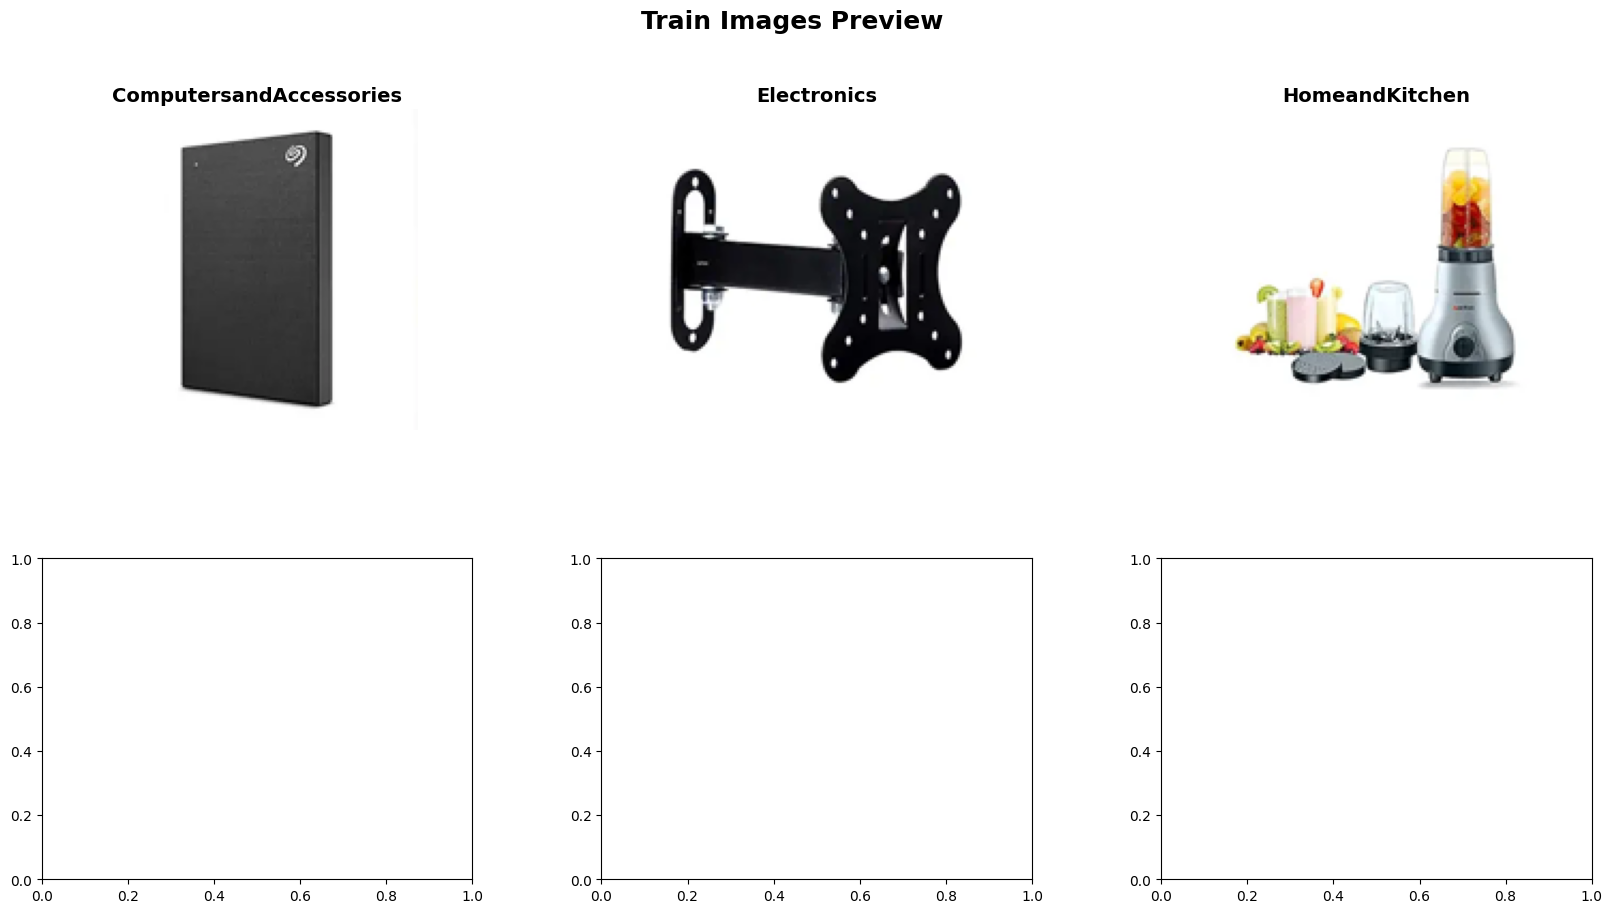

In [101]:
plt.rcParams["figure.figsize"] = (20, 10)
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace': 0.4, 'wspace': 0.3}) 

# categories = ['In-Ear', 'RemoteControls', 'Smartphones', 'SmartTelevisions', 'SmartWatches', 'USBCables']
# images = [In_Ear_img, RemoteControls_img, Smartphones_img, SmartTelevisions_img, SmartWatches_img, USBCables_img]
categories = ['ComputersandAccessories', 'Electronics', 'HomeandKitchen']
images = [ComputersandAccessories_img, Electronics_img, HomeandKitchen_img]

for i, (category, category_imgs) in enumerate(zip(categories, images)):  
    axs[i//3, i%3].imshow(category_imgs[0])
    axs[i//3, i%3].axis('off') 
    axs[i//3, i%3].set_title(category, fontsize=14, fontweight='bold') 

plt.suptitle('Train Images Preview', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [104]:
def load_data():
    datasets = ['base_images/train', 'base_images/test']    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")

        for folder in os.listdir(dataset):
            if folder == '.DS_Store':
                continue
            label = class_label[folder]
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                if file == '.DS_Store':
                    continue
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).convert('RGB').resize((150, 150))
                images.append(np.array(image))
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [105]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading base_images/train...


Processing ComputersandAccessories: 100%|██████████| 182/182 [00:00<00:00, 630.21it/s]


Loading base_images/test...


Processing ComputersandAccessories: 100%|██████████| 48/48 [00:00<00:00, 646.56it/s]


In [106]:
#Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [107]:
# Convert NumPy arrays to tensors
train_images_tensor = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_images_tensor = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images_tensor, train_labels_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images_tensor, test_labels_tensor))

# Set a buffer size for shuffling
buffer_size = 10000

train_dataset = train_dataset.shuffle(buffer_size=buffer_size, seed=25)
test_dataset =  test_dataset.shuffle(buffer_size=buffer_size, seed=25)

In [108]:
n_train = train_labels_tensor.shape[0]
n_test = test_labels_tensor.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))

Number of training examples: 643
Number of testing examples: 170


In [109]:
model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,430 (435.27 KB)

 Trainable params: 110,982 (433.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [110]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=20, 
                    validation_split = 0.2)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.2893 - loss: 1.8665 - val_accuracy: 0.0000e+00 - val_loss: 1.7805
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5890 - loss: 1.1398 - val_accuracy: 0.0000e+00 - val_loss: 1.8560
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5826 - loss: 1.0348 - val_accuracy: 0.0000e+00 - val_loss: 1.7976
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5646 - loss: 1.0108 - val_accuracy: 0.0000e+00 - val_loss: 1.7236
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5736 - loss: 0.9718 - val_accuracy: 0.0000e+00 - val_loss: 1.7120
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.5755 - loss: 0.9518 - val_accuracy: 0.0000e+00 - val_loss: 1.6532
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5767 - loss: 0.9579 - val_accuracy: 0.0000e+00 - val_loss: 1.5468
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6010 - loss: 0.9208 - val_accuracy: 0.0000

In [111]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the neural network.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].plot(history.history['accuracy'], 'b--o', label="Training Accuracy")
    axes[0].plot(history.history['val_accuracy'], 'r--o', label="Validation Accuracy")
    axes[0].set_title("Training vs Validation Accuracy", fontsize=14)
    axes[0].set_xlabel("Epochs", fontsize=12)
    axes[0].set_ylabel("Accuracy", fontsize=12)
    axes[0].legend(loc="lower right")
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], 'b--o', label="Training Loss")
    axes[1].plot(history.history['val_loss'], 'r--o', label="Validation Loss")
    axes[1].set_title("Training vs Validation Loss", fontsize=14)
    axes[1].set_xlabel("Epochs", fontsize=12)
    axes[1].set_ylabel("Loss", fontsize=12)
    axes[1].legend(loc="upper right")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

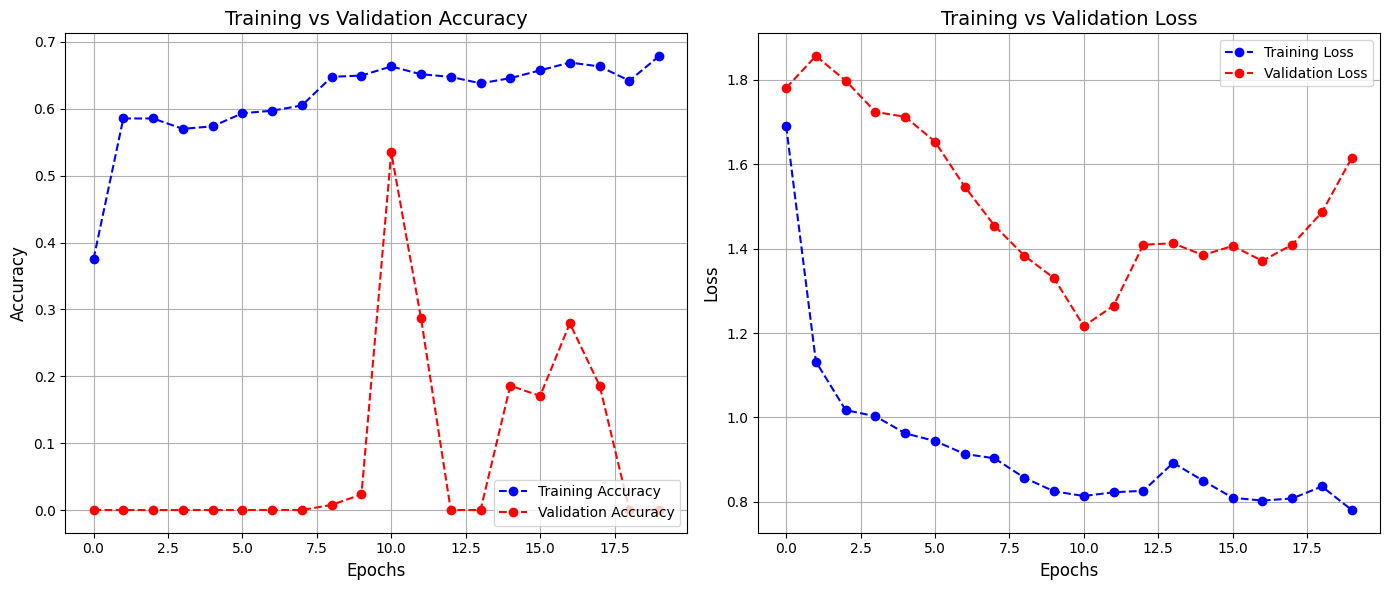

In [112]:
plot_accuracy_loss(history)

In [113]:
test_loss = model.evaluate(test_images, test_labels)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.1632 - loss: 2.1017 


In [114]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure(figsize=(3,3))
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


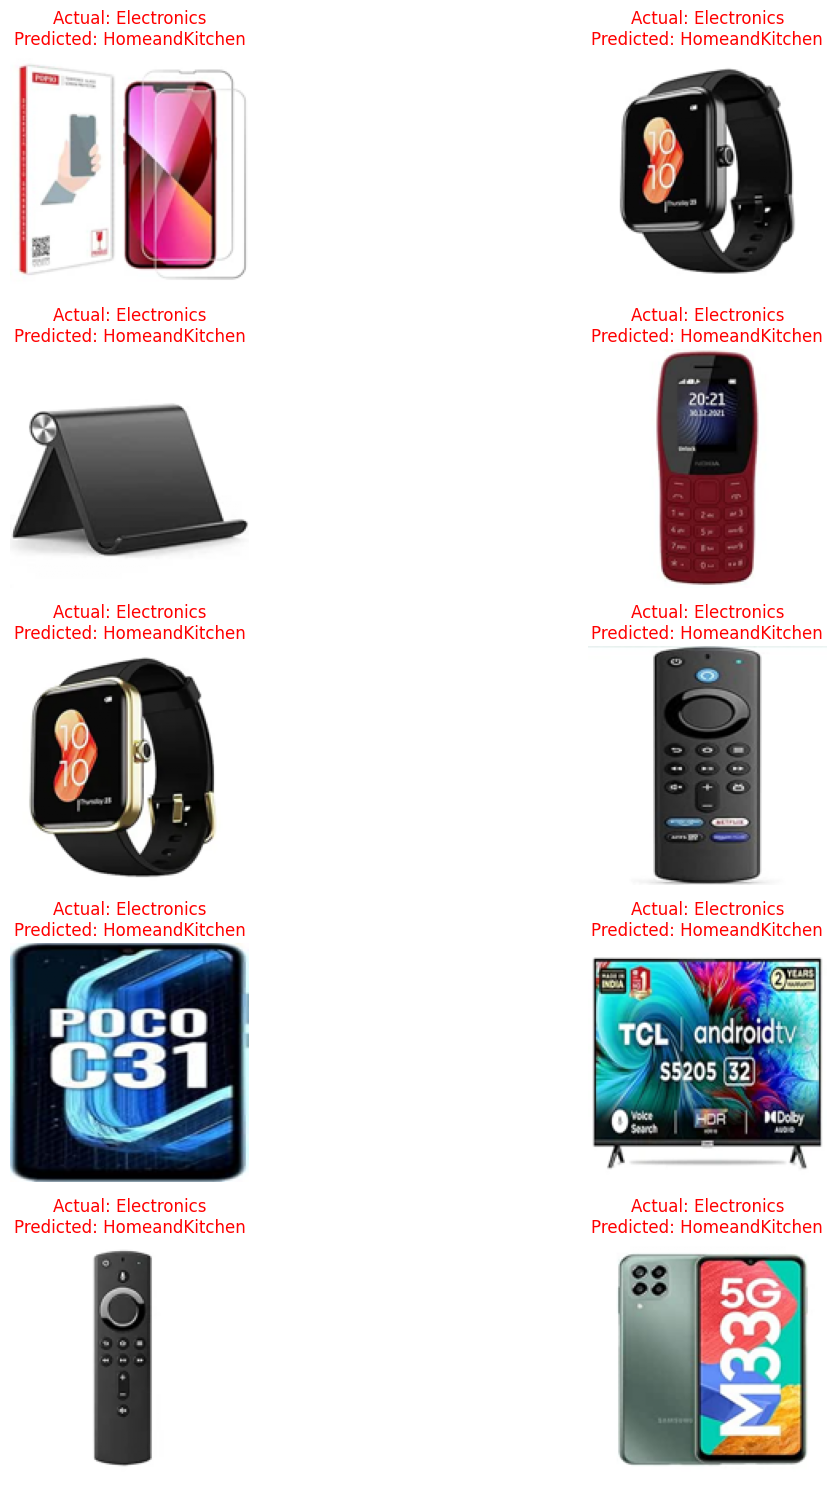

In [115]:
def display_multiple_predictions(class_names, images, labels, predictions, num_images=10):
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):

        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        actual_label = class_names[labels[i]]
        predicted_label = class_names[predictions[i]]
        color = 'green' if predicted_label == actual_label else 'red'
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", color=color)
        plt.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()
    
predictions = model.predict(test_images)  # Vector of probabilities
pred_labels = np.argmax(predictions, axis=1)  # Take the highest probability
display_multiple_predictions(class_names, test_images, test_labels, pred_labels, num_images=10)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step


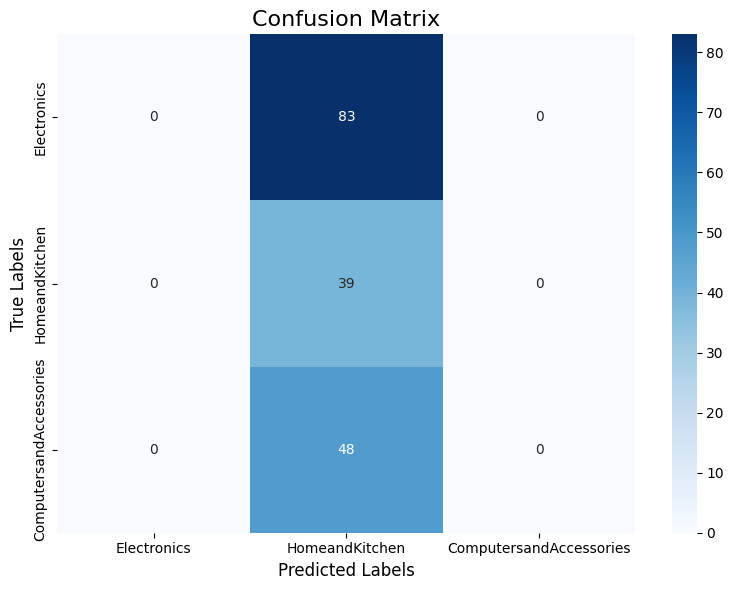

In [116]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    
    cm = confusion_matrix(true_labels, pred_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.tight_layout()
    plt.show()

predictions = model.predict(test_images) 
pred_labels = np.argmax(predictions, axis=1)  
plot_confusion_matrix(test_labels, pred_labels, class_names)